一、引入库函数

In [43]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

二、以基本面相似的股票进行完整的模拟

目前确定的两只股票：
1. 建设银行
2. 农业银行


In [44]:
end_date = '2018-12-31'
ncount = 500

# 建设银行
S1 = get_price('601939.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行
S2 = get_price('601288.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


三、进行线性建模

利用Kalman方程确定对应的关系，利用残差进行分析


In [45]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    return state_means[-1]


按照2018年12月31日的价格
建设银行价格为：6.37
农业银行价格为：3.6
beta 为第一个参数
alpha 为第二个参数

$\beta = 0.46181125 $

$\alpha = 0.47094559$

$AlgriBank = ConsBank * \beta + \alpha + \epsilon$

$ 3.6 = 6.37 * 0.46 + 0.47 + \epsilon$

$\epsilon = 0.199$

In [4]:
# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(S1,S2)
beta = kalman_beta(S1,S2)[0]
alpha = kalman_beta(S1,S2)[1]

计算出残差序列

In [5]:
res = S2 - np.dot(sm.add_constant(S1, prepend=False), beta_kf)

画出残差的图表

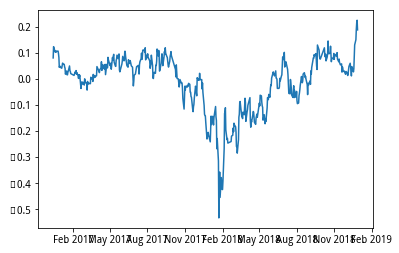

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(res.index),list(res.values))
plt.show()

In [7]:
np.mean(res.values[200:300])

-0.13849303472517555

根据结果可以看出，相应的残差序列并不在0均值的范围内波动

如果按照这个结果进行交易

## 会发现相应的交易机会不好 

四、对残差进行处理

开始进行时序分析建模

ADF检验总结一句话：如果序列是平稳的，则不存在单位根， 否则就会存在单位根。

平稳的定义：
1. 均值不变
2. 子序列之间的相关性不随时间变化而改变


In [8]:
# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]

In [9]:
Cadf_test(res)

0.15914901908216345

H0：there is unit root

因为概率不低于0.05，所以无法推翻H0

结论是的确存在Unit Root

In [10]:
test_stochastic(res)

4.849117064326043e-103

H0：原本的数据都是纯随机序列

因为概率低于0.05，所以可以推翻H0

结论就是序列是非纯随机序列

进行差分运算

In [11]:
res_diff = res - res.shift(1)
res_diff = res_diff.fillna(0)


std_deviation = np.std(res_diff)
mean = np.mean(res_diff)

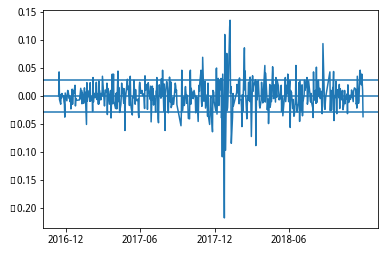

In [12]:
import matplotlib.dates as mdate 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(res_diff.index),list(res_diff.values))


# 设置时间日期格式
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))#设置时间标签显示格式
plt.xticks(pd.date_range(list(res_diff.index)[0],list(res_diff.index)[-1],freq='6M'))  

ax.axhline(std_deviation)
ax.axhline(-std_deviation)
ax.axhline(mean)

plt.show()

In [13]:
# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

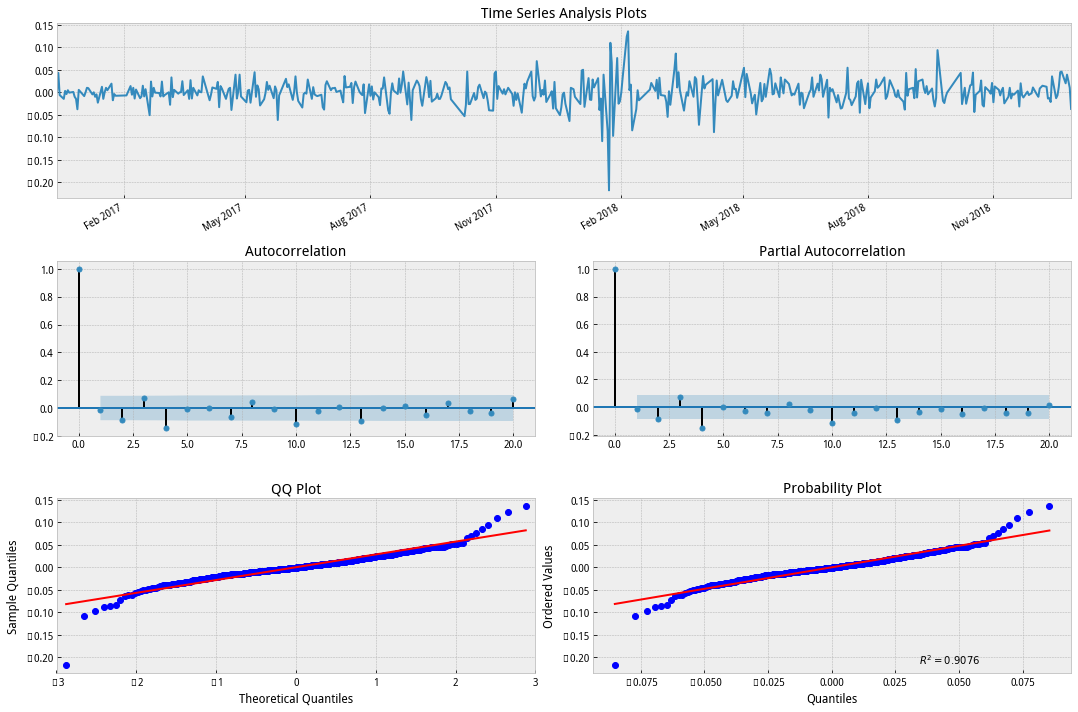

In [14]:
tsplot(res_diff,lags=20)

In [15]:
Cadf_test(res_diff)

8.2787959842375474e-24

H0：there is unit root

因为概率低于0.05，所以可以推翻H0

结论：不存在Unit Root，是平稳序列

In [16]:
test_stochastic(res_diff)

0.76379155469528859

H0：原本的数据都是纯随机序列

因为概率高于0.05，所以不可以推翻H0

结论：序列是纯随机序列

# 五、策略研究

策略：求出差分后的残差$\epsilon$

1. 确定kalman方程的beta、alpha
2. 确定相应的$\epsilon$
3. 求出$\epsilon$的差分值
4. 求出差分值的平均值、方差值
5. 价格推导公式如下：

t-1 时刻：$Q_{t-1} = \beta * P_{t-1} + \alpha + \epsilon_{t-1}$

t时刻：$Q_{t} = \beta * P_{t} + \alpha + \epsilon_{t}$

做处理，将t时刻的等式减去t-1时刻的等式，汇总后

$Q_{t} - Q_{t-1} = \beta * P_{t} + \alpha + \epsilon_{t} - \beta * P_{t-1} - \alpha - \epsilon_{t-1}$


$\epsilon_{t} - \epsilon_{t-1} = (Q_{t} - Q_{t-1}) - \beta * (P_{t} - P_{t-1})$

$Q_{t}$是因变量，$P_{t}$是自变量，t-1时刻的值为已观察到的值，$（\epsilon_{t} - \epsilon_{t-1}）$是随机变量，均值方差根据历史数据求出，根据上式可以得出：

$Q_{t} = (\epsilon_{t} - \epsilon_{t-1}) + \beta * (P_{t} - P_{t-1}) + Q_{t-1}$


结论：

$Q_{t}$是推导出来的值，$\epsilon_{t} - \epsilon_{t-1}$是随机变量（0均值），$\beta$是历史推导值，其他是观察值，所以如果观察到$Q_{t}$价格偏差较大，就可以推导出应该的价格

# 六、策略验证

1. 求出两只股票（建设银行是自变量$P_{t}$、农业银行是因变量$Q_{t}$）
2. 找出$\beta,\alpha$
3. 用2018-10到2019-2的数据进行验证，求出等式右边的值
4. 找出$\epsilon$，求出$\delta$
5. 画图，对比实际的$Q_{t}$，与观察到的$Q'_{t}$


In [3]:
# 求出两只股票
end_date = '2018-9-30'
ncount = 500

# 建设银行,P
S1 = get_price('601939.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行,Q
S2 = get_price('601288.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


In [4]:
# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(S1,S2)
beta = kalman_beta(S1,S2)[0]
alpha = kalman_beta(S1,S2)[1]

NameError: name 'kalman_beta' is not defined

In [ ]:
start_date = '2018-10-1'
end_date = '2019-2-28'

# 建设银行,P
S1_validation = get_price('601939.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行,Q
S2_validation = get_price('601288.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


In [ ]:
Q_infer = beta*(S1_validation - S1_validation.shift(1)) + S2_validation

gap = S2_validation - Q_infer

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

ax.plot(list(Q_infer.index),list(Q_infer.values),label ='infer value')

ax.plot(list(S2_validation.index),list(S2_validation.values),label ='actual value')

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 10))


ax1 = fig.add_subplot(111)

ax1.plot(list(Q_infer.index),list(Q_infer.values),label ='infer value')

ax1.plot(list(S2_validation.index),list(S2_validation.values),label ='actual value')

ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要

ax2.plot(list(gap.index),list(gap.values),label ='gap value')

ax2.axhline(np.std(gap))
ax2.axhline(-np.std(gap))
ax2.axhline(np.mean(gap))

plt.legend()
plt.show()

结论：

通过验证数据集的验证，可以看的确差距值也在0均值附近波动

# 七、策略实现

1. 利用历史价格，找出$\beta,\alpha$
2. 按照历史价格找出$\epsilon$，求出$\delta$
3. 用2018-10到2019-2的数据进行验证，按照每天收盘价，求出等式右边的值
4. 如果推测的价格的低于观察到的价格0.5个$\delta$则**买入**，如果高于观察的价格0.5个$\delta$，则**卖出**
5. 画图，描绘出买入点，卖出点
5. 利用cucum函数，计算收益率

## 计算大盘择时参数

每个状态的参数都按照一个比例进行计算，计算一段时间内（这段时间也是未来的参数）的仓位参数，通过仓位参数计算出收益率，标准有两个
1. 总的收益率越高
2. 失败概率最低

在每天的价格上增加了仓位的调整系数，这个系数是一个：持仓／总资产的数量（大于等于0）

t时刻的资产：持股资产比例 ＋ 现金资产比例

t时刻的资产：$$ 持股资产比例 * P（t+1) / P (t) + 现金资产比例 $$

引入t 时刻的持股资产比例 alpha

t 时刻的资产：$$ alpha * 1 + （1 - alpha）*1 = 1 $$
 
t + 1 时刻的资产：$$ alpha * 1 * P（t + 1) / P (t) + (1-alpha) * 1 $$

对数资产收益率：

$$ log ( alpha * 1* \frac {P（t+1)} {P (t)}  + (1-alpha)*1) 
/  1  $$

$$ log ( 1 + alpha * \frac {P(t+1) - P(t)}{P(t)} )$$

如果alpha为1，则回归到上面的公式$log(\frac {P(t+1)}{P(t)})$

In [46]:
# 求出两只股票
end_date = '2018-9-30'
ncount = 500

# 建设银行,P，自变量
S1 = get_price('601939.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行,Q，因变量
S2 = get_price('601288.XSHG', count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(S1,S2)
beta = kalman_beta(S1,S2)[0]
alpha = kalman_beta(S1,S2)[1]

In [47]:
res = S2 - np.dot(sm.add_constant(S1, prepend=False), beta_kf)

res_diff = res - res.shift(1)
res_diff = res_diff.fillna(0)


std_deviation = np.std(res_diff)
mean = np.mean(res_diff)

In [48]:
start_date = '2018-10-1'
end_date = '2019-2-28'

# 建设银行,P
S1_validation = get_price('601939.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 农业银行,Q
S2_validation = get_price('601288.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


Q_infer = beta*(S1_validation - S1_validation.shift(1)) + S2_validation

gap = S2_validation - Q_infer

gap =  gap.fillna(0)

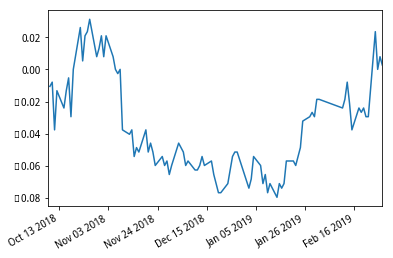

In [49]:
# 画出推测标的的收益率曲线，仅做演示用
S2_Yield = np.cumsum(np.log(S2_validation) - np.log(S2_validation.shift(1)) )

S2_Yield.plot()

## 回测数列处理

1. 确定买入点、卖出点数列
2. 整理数列，确定三个状态：
    - 0：与前面状态一致的状态，可以称为稳定状态
    - 1：买入状态：将现在的状态改变为买入状态
    - -1：卖出状态，将现在的状态改变为卖出状态
3. 确定一个状态变更列表
4. 对状态变更列表进行处理，处理原则：一开始设置为卖出状态；若为0，则与前状态一致；若为1，则变更为买入状态；若为-1 则变更为卖状态；如果状态已经是当前要变更的状态，则不作处理
5. 对状态变更列表进行差分，异或处理，确定状态跳变的时间点
6. 以状态跳变时间点的列表与买入点、卖出点数列进行并运算，得出新的买入点、卖出点数列
7. 以新的买入点、卖出点数列作为新的序列
8. 已新的序列（三状态：0，+1，-1）计算cucum()，计算仓位结果


示例：

|类别|第1天|第2天|第3天|第4天|第5天|第6天|第7天|第8天|第9天|第10天|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|1.买入点|0|1|0|0|0|0|0|1|0|0|
|2.卖出点|0|0|0|-1|0|0|-1|0|-1|0|
|3.混合序列|0|1|0|-1|0|0|-1|1|-1|0|
|4.状态序列|-1|1|1|-1|-1|-1|-1|1|-1|-1|
|5.状态差分|-1|-1|1|1|-1|-1|-1|-1|1|-1|
|6.状态异或|0|1|0|1|0|0|0|1|1|0|
|7.买入并|0|1|0|0|0|0|0|1|0|0|
|8.卖出并|0|0|0|-1|0|0|0|0|-1|0|
|9.新混合|0|1|0|-1|0|0|0|1|-1|0|
|10.累加运算|0|1|1|0|0|0|0|1|0|0|

最终使用10#序列与收益率相乘，得到最后收益率曲线，最终来画图

In [95]:
# 序列处理代码实现

buy_point_pd = gap < -std_deviation
sell_point_pd = gap > std_deviation

buy_point_list = [int(d) for d in buy_point_pd ]
sell_point_list = [-int(d) for d in sell_point_pd ]




def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new

    return np.cumsum(combine_list_new)

最终画图验证

In [1]:
pd.Series(S2_Yield*np.ones(len(S2_Yield))).plot()
np.cumsum(((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*position_generate(buy_point_list,sell_point_list))).plot()

NameError: name 'pd' is not defined

# JOB DONE

In [16]:
# 判断交易点

buy_point_pd = gap < -std_deviation

sell_point_pd = gap > std_deviation

# 构建相应的交易序列，明确在那些时间短持仓、或者空仓
# 有没有一次性的方法？

trade_pd = pd.Series()
trade_pd = trade_pd.reindex(list(sell_point_pd.index))


In [18]:
buy_point_pd

2018-10-08    False
2018-10-09    False
2018-10-10    False
2018-10-11    False
2018-10-12     True
2018-10-15    False
2018-10-16    False
2018-10-17    False
2018-10-18    False
2018-10-19     True
2018-10-22     True
2018-10-23    False
2018-10-24     True
2018-10-25     True
2018-10-26    False
2018-10-29    False
2018-10-30    False
2018-10-31    False
2018-11-01    False
2018-11-02     True
2018-11-05    False
2018-11-06    False
2018-11-07    False
2018-11-08    False
2018-11-09    False
2018-11-12    False
2018-11-13    False
2018-11-14    False
2018-11-15    False
2018-11-16    False
              ...  
2019-01-11    False
2019-01-14    False
2019-01-15     True
2019-01-16    False
2019-01-17    False
2019-01-18     True
2019-01-21    False
2019-01-22    False
2019-01-23    False
2019-01-24    False
2019-01-25     True
2019-01-28    False
2019-01-29     True
2019-01-30    False
2019-01-31     True
2019-02-01    False
2019-02-11    False
2019-02-12    False
2019-02-13    False


In [28]:
trade_pd

Series([], dtype: float64)

In [21]:
sell_point_pd.head()

2018-10-08    False
2018-10-09    False
2018-10-10    False
2018-10-11     True
2018-10-12    False
Name: close, dtype: bool

In [22]:
buy_point_pd.head()

2018-10-08    False
2018-10-09    False
2018-10-10    False
2018-10-11    False
2018-10-12     True
Name: close, dtype: bool

In [20]:
def proper_model(data_ts, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

In [ ]:
proper_model(data_ts, maxLag)

In [41]:
# 根据不同的文件名，读取相应的数据
price_data = pd.read_csv('price0308.csv',index_col = 0)
# nan处理
price_data = price_data.fillna(0)
# inf处理
price_data[np.isinf(price_data)] = 0


In [42]:
price_data

,000001.XSHE,000002.XSHE,000063.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000402.XSHE,...,603156.XSHG,603160.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603799.XSHG,603833.XSHG,603858.XSHG,603986.XSHG,603993.XSHG
2018-05-15,10.95,26.70,31.31,7.72,3.20,4.11,4.85,55.22,8.01,8.73,...,68.66,73.45,50.08,73.21,69.99,83.37,146.11,37.26,116.79,8.22
2018-05-16,10.74,26.20,31.31,7.69,3.17,4.07,4.79,54.40,7.98,8.73,...,69.04,72.07,55.09,73.87,72.09,82.35,146.26,40.53,120.64,8.08
2018-05-17,10.66,25.77,31.31,7.67,3.13,4.05,4.75,53.12,8.11,8.86,...,66.75,72.25,60.60,75.29,68.53,80.99,145.99,39.79,121.54,8.00
2018-05-18,10.79,26.12,31.31,7.75,3.15,4.08,4.78,53.89,8.16,9.02,...,65.99,72.91,66.66,74.46,68.71,81.85,146.52,39.38,119.41,8.09
2018-05-21,10.78,26.04,31.31,7.77,3.19,4.10,4.83,53.95,8.08,9.09,...,65.44,74.64,73.33,78.57,69.64,82.33,145.67,39.60,131.35,8.16
2018-05-22,10.70,25.71,31.31,7.74,3.18,4.10,4.81,52.63,8.17,9.00,...,66.32,74.46,80.66,79.39,69.71,83.32,148.22,39.12,128.87,8.01
2018-05-23,10.49,25.78,31.31,7.61,3.16,4.06,4.78,51.80,8.14,8.91,...,65.29,73.38,88.73,80.81,70.53,79.76,148.68,39.31,128.27,7.70
2018-05-24,10.45,25.64,31.31,7.62,3.14,4.05,4.71,50.90,8.01,9.02,...,65.14,72.04,97.60,80.63,69.39,79.82,144.48,39.32,123.23,7.67
2018-05-25,10.43,25.39,31.31,7.50,3.12,4.04,4.66,50.59,8.14,8.99,...,63.90,70.84,107.36,78.07,69.37,75.76,144.45,40.43,120.65,7.43
2018-05-28,10.43,25.49,31.31,7.59,3.10,4.01,4.66,51.94,8.29,9.06,...,64.19,69.04,118.10,78.66,71.38,75.93,144.15,41.53,116.00,7.43


二、检验残差的平稳性、均值回归性

In [43]:
# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res_pd):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res_pd)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]

三、逐个的寻找配对的关系

In [37]:
# 暂时先用i,j代替，之后用for循环
i = 1
j = 5

data = price_data

keys = data.keys()

S1 = data[keys[i]]
S2 = data[keys[j]]

# 构建检验序列
Validation_data = np.log(S1/S2).diff()

Validation_data = Validation_data.fillna(0)

In [38]:
Cadf_test(Validation_data)

1.5942066780128784e-24

In [39]:
test_stochastic(Validation_data)

0.33958425184074392

In [ ]:
data = price_data

n = data.shape[1]

keys = data.keys()
pairs = []
for i in range(n):
    for j in range(i+1, n):
        S1 = data[keys[i]]
        S2 = data[keys[j]]

        # 构建检验序列
        Validation_data = np.log(S1/S2).diff()

        Validation_data = Validation_data.fillna(0)
        
        Cadf_factor = Cadf_test(Validation_data)
        stochastic_factor = test_stochastic(Validation_data)
        
        if  (Cadf_factor < 0.05) and  (stochastic_factor < 0.05):
            print "找到配对序列：%s，%s"%(str(keys[i]),str(keys[j]))
            pairs.append([keys[i],keys[j],Cadf_factor,stochastic_factor])


找到配对序列：000001.XSHE，000063.XSHE
找到配对序列：000001.XSHE，000408.XSHE
找到配对序列：000001.XSHE，000413.XSHE
找到配对序列：000001.XSHE，000415.XSHE
找到配对序列：000001.XSHE，000630.XSHE
找到配对序列：000001.XSHE，000725.XSHE
找到配对序列：000001.XSHE，000839.XSHE
找到配对序列：000001.XSHE，000959.XSHE
找到配对序列：000001.XSHE，000963.XSHE
找到配对序列：000001.XSHE，002032.XSHE
找到配对序列：000001.XSHE，002236.XSHE
找到配对序列：000001.XSHE，002252.XSHE
找到配对序列：000001.XSHE，002310.XSHE
找到配对序列：000001.XSHE，002411.XSHE
找到配对序列：000001.XSHE，002450.XSHE
找到配对序列：000001.XSHE，002508.XSHE
找到配对序列：000001.XSHE，002736.XSHE
找到配对序列：000001.XSHE，300003.XSHE
找到配对序列：000001.XSHE，300017.XSHE
找到配对序列：000001.XSHE，300033.XSHE
找到配对序列：000001.XSHE，300072.XSHE
找到配对序列：000001.XSHE，300433.XSHE
找到配对序列：000001.XSHE，600221.XSHG
找到配对序列：000001.XSHE，600297.XSHG
找到配对序列：000001.XSHE，600339.XSHG
找到配对序列：000001.XSHE，600518.XSHG
找到配对序列：000001.XSHE，600739.XSHG
找到配对序列：000001.XSHE，600816.XSHG
找到配对序列：000001.XSHE，600837.XSHG
找到配对序列：000001.XSHE，600887.XSHG


In [ ]:
# 存储相应的配对股票数据
pairs_pd = pd.DataFrame(columns=['pairs1','pairs2','adf_factor','stochastic_factor'],data=pairs)
pairs_pd.to_csv("pairs_validation.csv")

一、挑选沪深300指数，与沪深300指数对比，利用kalman方程求出残差

In [2]:
def kalman_beta(sec1 = '000858.XSHE' ,sec2 = '000300.XSHG',count = 400, end_date = '2015-3-1'):
    # 赋初值
    secs = [sec1, sec2]
    ncount = count
    end_date = end_date
    
    # 获取价格数据
    data = get_price(secs, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']
    data.index.name = 'Date'
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(data[secs[0]].values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(data[secs[1]][:, np.newaxis])
    return state_means[-1]


# 函数名：Res_cal
# 输入参数：
# 1、sec1：比对的第一支股票
# 2、sec2：比对的第二只股票
# 3、ncount：样本数
# 4、end_date：终止时间
# 输出参数：
# 序列：
# 输出残差序列

def Res_cal(sec1,sec2,ncount,end_date):
    # 将股票改造成数组，并对参数赋初值
    secs = [sec1, sec2]
    ncount = ncount
    end_date = end_date
    
    # 获得价格数据
    p_data = get_price(secs, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

    # 基于kalman方程获得alpha、beta
    beta_kf = kalman_beta(sec1 = sec1 ,sec2 = sec2,count = ncount, end_date = end_date)
    beta = beta_kf[0]
    alpha = beta_kf[1]

    # 利用alpha、beta计算两个股票的残差
    # 注意：
    # 1、股票1与股票2的顺序，sec2 = sec1 * beta + alpha
    # 2、beta、alpha均包含在beta_kf中
    res_pd = pd.DataFrame(p_data[secs[1]]- np.dot(sm.add_constant(p_data[secs[0]], prepend=False), beta_kf))
    res_pd.columns = ['res']
  
    # 无效值填充
    res_pd = res_pd.fillna(0)
    

    return res_pd


生成残差序列

In [3]:
res_pd = Res_cal(sec1 = '000858.XSHE' ,sec2 = '000300.XSHG',ncount = 400, end_date = '2018-3-1')

二、检验残差的平稳性、均值回归性

In [4]:
# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res_pd):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res_pd["res"])
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]

In [5]:
# 注意选取时要截取后面一段，确保准确性
Cadf_test(res_pd.iloc[-200:-10])

0.60446096098810431

In [6]:
test_stochastic(res_pd.iloc[-200:-10])

2.7588933829765305e-42

三、确定ARMA的阶数

ARMA(p,q)是AR(p)和MA(q)模型的组合，关于p和q的选择，一种方法是观察自相关图ACF和偏相关图PACF, 另一种方法是通过借助AIC、BIC统计量自动确定。由于我有几千个时间序列需要分别预测，所以选取自动的方式，而BIC可以有效应对模型的过拟合，因而选定BIC作为判断标准。


In [7]:
def proper_model(data_ts, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

In [8]:
model_para = proper_model(res_pd.iloc[-200:-10], 10)

/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization f

/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization f

四、拟合ARAM

对于差分后的时间序列，运用于ARMA时该模型就被称为ARMIA，在代码层面改写为model = ARIMA(timeseries, order=(p,d,q))，但是实际上，用差分过的序列直接进行ARMA建模更方便，之后添加一步还原的操作即可。

参考：
1. 用statsmodel这个包来进行预测，很奇怪的是我从来没成功过，只能进行下一步（之后一天）的预测，多天的就无法做到了
2. predict_ts = result_arma.predict(start=val.loc[0,'date'], end=val.loc[val.shape[0]-1,'date']) ，利用这个方法可以正确预测出一段时间范围内的结果



In [9]:
model_para

(2096.5525118413502,
 9,
 0,
 <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f3fa2812c10>)

In [10]:
model_fit = model_para[3]

output = model_fit.forecast(steps=5, exog=None, alpha=0.05)

In [11]:
output

(array([ 264.2499769 ,  252.6526545 ,  315.86473891,  322.51634883,
         347.45482915]),
 array([  67.67234559,   94.13513324,  114.14819259,  129.52957898,
         146.57082903]),
 array([[ 131.6146168 ,  396.88533701],
        [  68.15118368,  437.15412532],
        [  92.13839253,  539.59108529],
        [  68.64303911,  576.38965856],
        [  60.18128308,  634.72837523]]))

In [12]:
res_pd.iloc[-11:]

,res
2018-02-08,244.877026
2018-02-09,115.029382
2018-02-12,1.386388
2018-02-13,11.077482
2018-02-14,-33.944971
2018-02-22,-126.850097
2018-02-23,-85.116898
2018-02-26,19.347590
2018-02-27,83.525847
2018-02-28,141.159241
